In [4]:
import numpy as np
import os
import numba
import time
import dask

import dask.array as da
from dask.delayed import delayed
from dask.distributed import Client, LocalCluster
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl

import ipywidgets as widgets
from ipywidgets import interactive

from scipy.optimize import least_squares
#from scipy.ndimage.interpolation import shift 
import scipy.ndimage as ndi
import scipy.sparse as sp
from scipy.interpolate import interp1d

from skimage import filters


from Registration import *

In [5]:
plt.rcParams["figure.figsize"] = [12., 8.]
cluster = LocalCluster(n_workers=1, threads_per_worker=8)
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:54815 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 8 Memory: 34.23 GB


In [6]:
client.upload_file('Registration.py')

def plot_stack(images, n, grid=False):
    """Plot the n-th image from a stack of n images.
    For interactive use with ipython widgets"""
    im = images[n, :, :].compute()
    plt.figure(figsize=[12,10])
    plt.imshow(im.T, cmap='gray', vmax=im.max())
    if grid:
        plt.grid()
    plt.show()

In [7]:
folder = r'./data'
#name = '20171120_160356_3.5um_591.4_IVhdr'
#start, stop, stride, dE = 40, -1, 1, 10 #BF

name = '20171120_215555_3.5um_583.1_IVhdr_DF2'
start, stop, stride, dE = 0, -1, 1, 10 #DF
Eslice = slice(start, stop, stride)

# Grab a window of 2*fftsize around the center of the picture
fftsize=256 * 2 // 2
z_factor = 1

In [8]:
original = xr.open_dataset(os.path.join(folder, name + '_detectorcorrected.nc'), chunks={'time': dE})
original = original.Intensity.data

In [9]:
interactive(lambda n: plot_stack(original, n), 
            n=widgets.IntSlider(original.shape[0]//2, 0, original.shape[0]-1, 1, continuous_update=False)
           ) 

interactive(children=(IntSlider(value=206, continuous_update=False, description='n', max=411), Output()), _dom…

In [10]:
# Step 1 to 3 of the algorithm as described in paper.
sobel = crop_and_filter(original[Eslice,...].rechunk({0:dE}), sigma=3, finalsize=2*fftsize)
sobel = (sobel - sobel.mean(axis=(1,2), keepdims=True)) #.persist()  
sobel

,Array,Chunk
Bytes,861.93 MB,20.97 MB
Shape,"(411, 512, 512)","(10, 512, 512)"
Count,337 Tasks,42 Chunks
Type,float64,numpy.ndarray


In [11]:
# Step 4 of the algorithm as described in paper.
Corr = dask_cross_corr(sobel)
Corr

C:\ProgramData\Anaconda3\lib\site-packages\dask\array\core.py:3855: PerformanceWarning: Increasing number of chunks by factor of 42
  **blockwise_kwargs


,Array,Chunk
Bytes,354.25 GB,209.72 MB
Shape,"(411, 411, 512, 512)","(10, 10, 512, 512)"
Count,23437 Tasks,1764 Chunks
Type,float64,numpy.ndarray


In [12]:
# Plot combination of original images, filtered images, crosscorrelation 
# for illustration purposes
def plot_corr(i,j, save=False):
    #fig = plt.figure(figsize=(8.2, 3.5), constrained_layout=True)
    fig = plt.figure(figsize=(4, 7), constrained_layout=True)
    fig.set_constrained_layout_pads(hspace=0.0, wspace=0.06)
    #gs = mpl.gridspec.GridSpec(2, 3,
    #                   width_ratios=[1, 1, 2.9],
    #                   #height_ratios=[4, 1]
    #                   )
    
    gs = mpl.gridspec.GridSpec(3, 2,
                       height_ratios=[1, 1, 1.8],
                               figure=fig,
                       )
    
    ax0 = plt.subplot(gs[0, 0])
    ax1 = plt.subplot(gs[1, 0])
    ax2 = plt.subplot(gs[0, 1])
    ax3 = plt.subplot(gs[1, 1])
    ax4 = plt.subplot(gs[2, :]) #2grid((2, 4), (0, 2), rowspan=2, colspan=2)
    ax0.imshow(original[i*stride + start,(640-fftsize):(640+fftsize),(512-fftsize):(512+fftsize)].T, 
               cmap='gray', interpolation='none')
    ax0.set_title(f'i={i*stride + start}')
    ax1.imshow(sobel[i,...].T, cmap='gray')
    ax2.imshow(original[j*stride + start,(640-fftsize):(640+fftsize),(512-fftsize):(512+fftsize)].T,
               cmap='gray', interpolation='none')
    ax2.set_title(f'j={j*stride + start}')
    ax3.imshow(sobel[j,...].T,
               cmap='gray', interpolation='none')
    im = ax4.imshow(Corr[i,j,...].compute().T, extent=[-fftsize, fftsize, -fftsize, fftsize], interpolation='none')
    ax4.axhline(0, color='white', alpha=0.5)
    ax4.axvline(0, color='white', alpha=0.5)
    for ax in [ax2, ax3]:
        ax.yaxis.set_label_position("right")
        ax.tick_params(axis='y', labelright=True, labelleft=False)
    plt.colorbar(im, ax=ax4)
    if save:
        #Saving Figure for paper.
        plt.savefig('autocorrelation.pdf', dpi=300)
    plt.show()
    return fig

widget = interactive(plot_corr, 
            i=widgets.IntSlider(58-start,0,sobel.shape[0]-1,1, continuous_update=False), 
            j=widgets.IntSlider(100-start,0,sobel.shape[0]-1,1, continuous_update=False),
            save=False
           )
display(widget)

interactive(children=(IntSlider(value=58, continuous_update=False, description='i', max=410), IntSlider(value=…

In [13]:
# Step 5 of the algorithm
weights, argmax = max_and_argmax(Corr)

In [14]:
# Do actual computations; get a cup of coffee
t = time.time()
Wc, Mc = calculate_halfmatrices(weights, argmax, fftsize=fftsize)
print(time.time()-t)

804.4822609424591


In [15]:
### Step 6 of the algorithm
wc_diag = np.atleast_2d(np.diag(Wc))
W_n = Wc / np.sqrt(wc_diag.T*wc_diag)

In [16]:
# Plot W, DX and DY to pick a value for W_{min} (Step 7 of algorithm)
def plot_masking(min_normed_weight, save=False):
    extent = [start, stop, stop, start]
    fig, axs = plt.subplots(1, 3, figsize=(8, 2.5), constrained_layout=True)
    im = {}
    im[0] = axs[0].imshow(Mc[0], cmap='seismic', extent=extent, interpolation='none')
    im[1] = axs[1].imshow(Mc[1], cmap='seismic', extent=extent, interpolation='none')
    im[2] = axs[2].imshow(W_n - np.diag(np.diag(W_n)), cmap='inferno', 
                          extent=extent, clim=(0.0, None), interpolation='none')
    axs[0].set_ylabel('$j$')
    fig.colorbar(im[0], ax=axs[:2], shrink=0.82, fraction=0.1)
    axs[0].contourf(W_n, [0, min_normed_weight], 
                    colors='black', alpha=0.6, 
                    extent=extent, origin='upper')
    axs[1].contourf(W_n, [0, min_normed_weight], 
                    colors='black', alpha=0.6, 
                    extent=extent, origin='upper')
    CF = axs[2].contourf(W_n, [0, min_normed_weight], 
                         colors='white', alpha=0.2, 
                         extent=extent, origin='upper')
    cbar = fig.colorbar(im[2], ax=axs[2], shrink=0.82, fraction=0.1)
    cbar.ax.fill_between([0,1], 0, min_normed_weight, color='white', alpha=0.2)
    for i in range(3):            
        axs[i].set_xlabel('$i$')
        axs[i].tick_params(labelbottom=False, labelleft=False)  
    axs[0].set_title('$DX_{ij}$')
    axs[1].set_title('$DY_{ij}$')
    axs[2].set_title('$W_{ij}$')
    if save:
        plt.savefig('shiftsandweights.pdf', dpi=300)
    plt.show()
    return min_normed_weight

widget = interactive(plot_masking, 
                     min_normed_weight=widgets.FloatSlider(value=0.15, min=0., max=1, 
                                                      step=0.01, continuous_update=False),
                     save=False
               )
display(widget)

interactive(children=(FloatSlider(value=0.15, continuous_update=False, description='min_normed_weight', max=1.…

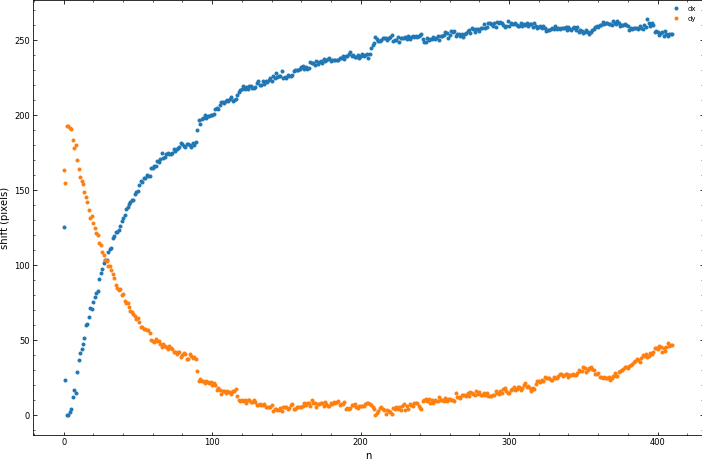

In [17]:
# Part two of step 7 of the algorithm
min_norm = widget.result
nr = np.arange(Wc.shape[0])*stride + start
coords, weightmatrix, DX, DY, row_mask = threshold_and_mask(min_norm, Wc, Mc, nr)
#Step 8 of the algorithm: reduce the shift matrix to two vectors of absolute shifts
dx, dy = calc_shift_vectors(DX, DY, weightmatrix)
plt.plot(coords, dx, '.', label='dx')
plt.plot(coords, dy, '.', label='dy')
plt.xlabel('n')
plt.ylabel('shift (pixels)')
plt.legend()

In [18]:
# Interpolate the shifts for all values not in coords
shifts = np.stack(interp_shifts(coords, [dx, dy], n=original.shape[0]), axis=1)
neededMargins = np.ceil(shifts.max(axis=0)).astype(int)
shifts = da.from_array(shifts, chunks=(dE,-1))
shifts

dask.array<array, shape=(412, 2), dtype=float64, chunksize=(10, 2), chunktype=numpy.ndarray>

In [19]:
#Step 9, the actual shifting of the original images

#Inferring output dtype is not supported in dask yet, so we need original.dtype here.
@da.as_gufunc(signature="(i,j),(2)->(i,j)", output_dtypes=original.dtype, vectorize=True)
def shift_images(image, shift):
    """Shift image over shift."""
    return ndi.shift(image, shift=shift, order=1)

padded = da.pad(original.rechunk({0:dE}), 
                ((0, 0), 
                 (0, neededMargins[0]), 
                 (0, neededMargins[1])
                ),
                mode='constant'
               )
corrected = shift_images(padded.rechunk({1:-1, 2:-1}), shifts)

In [20]:
# Do an interactive viewer to inspect the results
interactive(lambda n: plot_stack(corrected, n, grid=True), 
            n=widgets.IntSlider(corrected.shape[0]//4,0,corrected.shape[0]-1,1, continuous_update=False)
           ) 

interactive(children=(IntSlider(value=103, continuous_update=False, description='n', max=411), Output()), _dom…

In [21]:
# Save the results to zarr
import zarr
from numcodecs import Blosc
compressor = Blosc(cname='zstd', clevel=1, shuffle=Blosc.SHUFFLE)
corrected.to_zarr(os.path.join(folder, name + '_driftcorrected.zarr'), 
                  overwrite=True, compressor=compressor)

In [ ]:
#Or, although parallel access to HDF5 is hard, so go single process, save to hdf5
with dask.config.set(scheduler='threads'):  
    corrected.to_hdf5(folder + name + r'\driftCorrected.h5', '/stack')